## Import Parameter

### Classes Import

In [51]:
import os
import math
import pandas as pd
import random
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.optimize import curve_fit

### Ploting Import

In [52]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array

## Pauli matrix ( normal and sparse )

In [53]:
j = 1
h = 0.5
hbar = 1
SigmaX = np.array([[0,1],[1,0]])
SigmaY = np.array([[0,-1j],[1j,0]])
SigmaZ = np.array([[1,0],[0,-1]])
sparseSigmaX = sparse.csr_matrix([[0,1],[1,0]]).astype(float)
sparseSigmaY = sparse.csr_matrix([[0,-1j],[1j,0]]).astype(float)
sparseSigmaZ = sparse.csr_matrix([[1,0],[0,-1]]).astype(float)
Sx = hbar/2*SigmaX
Sy = hbar/2*SigmaY
Sz = hbar/2*SigmaZ
sparseSx = hbar/2*sparseSigmaX
sparseSy = hbar/2*sparseSigmaY
sparseSz = hbar/2*sparseSigmaZ
I = np.array([[1,0],[0,1]])
sparseI = sparse.csr_matrix(I).astype(float)



/home/aronton/anaconda3/lib/python3.8/site-packages/scipy/sparse/data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),


## $H$ = $\sum_{i}JH^{x}_{i}H^{x}_{i+1} + hzH^{z}_{i} + ih_{x}H^{x}_{i}$

## Hamiltonian Function

In [54]:
def Hamiltonain(L,Sx,Sy,Sz,I,j,hx,hz):

    Sxtot = np.zeros((2**L, 2**L))
    Sytot = np.zeros((2**L, 2**L))
    Sztot = np.zeros((2**L, 2**L))
    Htot = np.zeros((2**L, 2**L))
    SxList = []
    SyList = []
    SzList = []

    for k in range(L):
        x = Sx
        y = Sy
        z = Sz
        if(k == 0):
            for i in range(L-1):
                x = np.kron(x,I)
                y = np.kron(y,I)
                z = np.kron(z,I)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        elif(k == L-1):
            for i in range(L-1):
                x = np.kron(I,x)
                y = np.kron(I,y)
                z = np.kron(I,z)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        else:
            for i in range(k):
                x = np.kron(I,x)
                y = np.kron(I,y)
                z = np.kron(I,z)
            for i in range(k, L-1):
                x = np.kron(x,I)
                y = np.kron(y,I)
                z = np.kron(z,I)
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)

    # for i in range(L):
    #     if i < L-1:
    #         Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
    #     else:
    #         Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]

    if(hx == 0):
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] 
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] 
    else:
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]

    for i in range(L):
        Sxtot = Sxtot + SxList[i]
        Sytot = Sytot + SyList[i]
        Sztot = Sztot + SzList[i]
    
    return Htot, Sztot, SzList, Sxtot, SxList


def sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,j,hx,hz):

    Sxtot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Sytot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Sztot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    Htot = sparse.csr_matrix((2**L, 2**L)).astype(float)
    SxList = []
    SyList = []
    SzList = []

    for k in range(L):
        x = sparseSx
        y = sparseSy
        z = sparseSz
        if(k == 0):
            for i in range(L-1):
                x = sparse.kron(x,sparseI,format = 'csr')
                y = sparse.kron(y,sparseI,format = 'csr')
                z = sparse.kron(z,sparseI,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        elif(k == L-1):
            for i in range(L-1):
                x = sparse.kron(sparseI,x,format = 'csr')
                y = sparse.kron(sparseI,y,format = 'csr')
                z = sparse.kron(sparseI,z,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)
        else:
            for i in range(k):
                x = sparse.kron(sparseI,x,format = 'csr')
                y = sparse.kron(sparseI,y,format = 'csr')
                z = sparse.kron(sparseI,z,format = 'csr')
            for i in range(k, L-1):
                x = sparse.kron(x,sparseI,format = 'csr')
                y = sparse.kron(y,sparseI,format = 'csr')
                z = sparse.kron(z,sparseI,format = 'csr')
            SxList.append(x)
            SyList.append(y)
            SzList.append(z)

    if(hx == 0):
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] 
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] 
    else:
        for i in range(L):
            if i < L-1:
                Htot = Htot - j*SxList[i] @ SxList[i+1] - hz*SzList[i] - 1j*hx*SxList[i]
            else:
                Htot = Htot - j*SxList[i] @ SxList[0] - hz*SzList[i] - 1j*hx*SxList[i]


    for i in range(L):
        Sxtot = Sxtot + SxList[i]
        Sytot = Sytot + SyList[i]
        Sztot = Sztot + SzList[i]

    return Htot, Sztot, SzList, Sxtot, SxList
    
   

## 實數 Hamiltonian 做 ED

## Real Hamiltonian using dense matrix

### Calculation 11s

In [55]:
Llist = np.linspace(4,10,(12-4)//2,dtype = int)
print(Llist)
hz = np.linspace(0,1,11)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
entropy = []
np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


for l in range(len(Llist)):
    L = Llist[l]
    entropy.append(np.zeros((L+1,len(hz))))
    for hz_i in range(len(hz)):
        H,ztot,zlist,xtot,xList = Hamiltonain(L,Sx,Sy,Sz,I,1,0,hz[hz_i])
        ee, v = la.eigh(H)
        eex, vx = la.eigh(H + 0.01*xtot)
        E0[l,hz_i] = ee[0]/L
        E1[l,hz_i] = ee[1]/L
        gap[l,hz_i] = ee[1] - ee[0]
        lamda[l,hz_i] = 1/(ee[1] - ee[0])/L
        SzE[l,hz_i] = v[:,0] @ zlist[0]  @ v[:,0]
        SxE[l,hz_i] = vx[:,0] @ xList[0]  @ vx[:,0]
        Na = np.linspace(0,L,L+1,dtype = int)
        for na in range(len(Na)):
            rv = np.reshape(v[:,0], (2**Na[na],2**(L-Na[na])))
            s = np.linalg.svd(rv,  compute_uv=False)
            for svalue in s:
                entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)


[ 4  6  8 10]


<ipython-input-55-f7412e1ecfa6>:24: RuntimeWarning: divide by zero encountered in double_scalars
  lamda[l,hz_i] = 1/(ee[1] - ee[0])/L


### Data Plot

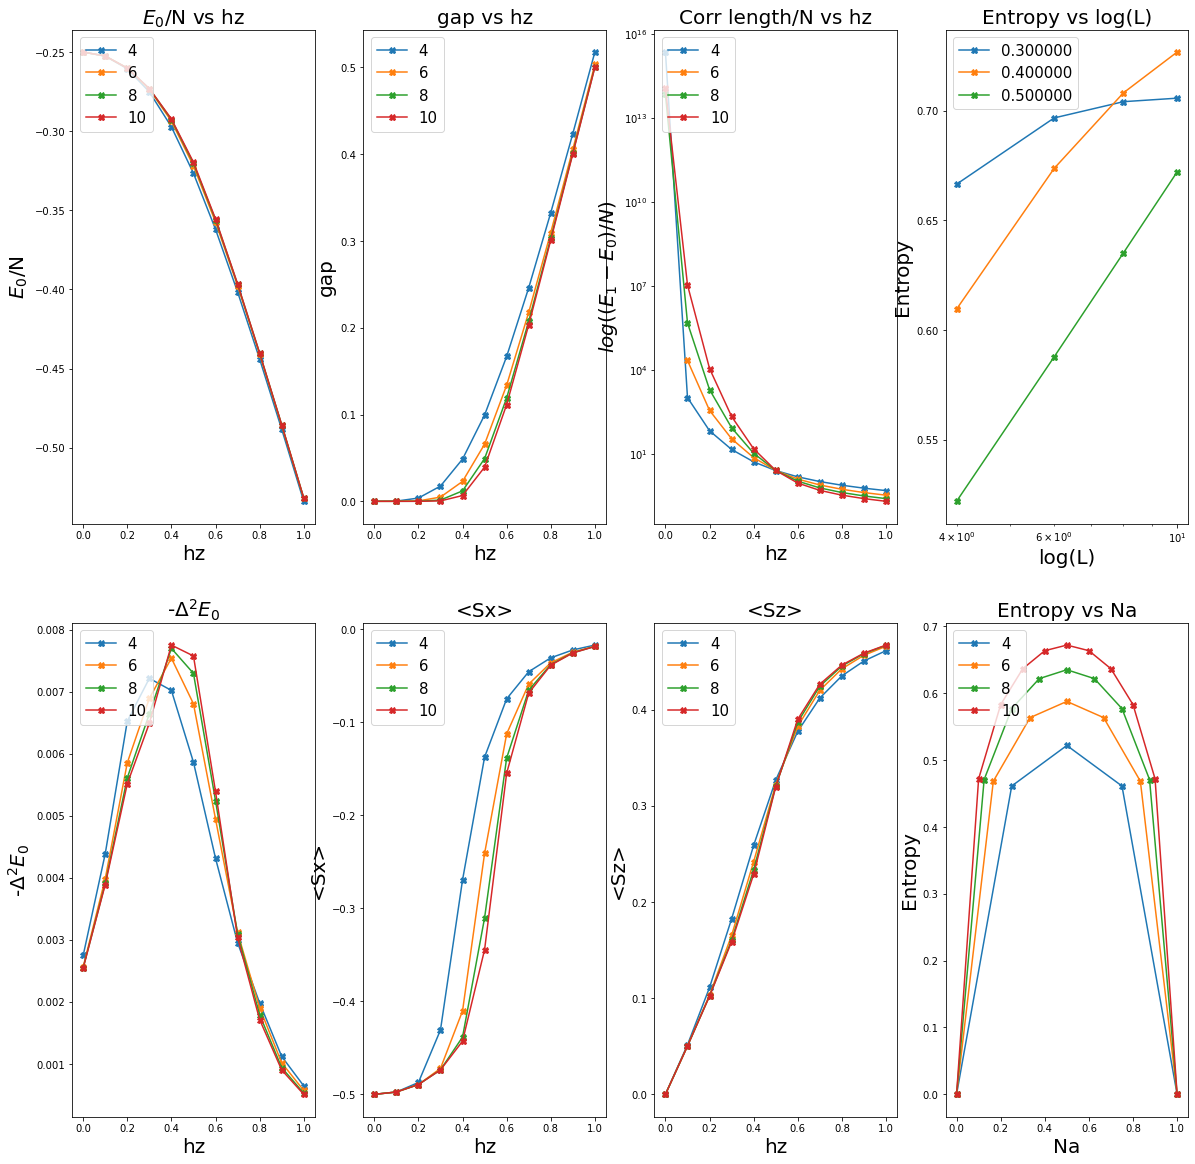

In [56]:
fig, ax = plt.subplots(2,4,figsize=(20,20))
entropyForAsize = np.zeros((len(Llist),len(hz)))
for l in range(len(Llist)):
    L = Llist[l]
    ax[0][0].plot(hz[:],E0[l,:], "-X", label = "%d" %L)
    ax[0][0].set_title("$E_0$/N vs hz", fontsize = 20)
    ax[0][0].set_ylabel("$E_0$/N", fontsize = 20)
    ax[0][0].set_xlabel("hz", fontsize = 20)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    ax[0][1].plot(hz[:],gap[l,:], "-X", label = "%d" %L)
    ax[0][1].set_title("gap vs hz", fontsize = 20)
    ax[0][1].set_ylabel("gap", fontsize = 20)
    ax[0][1].set_xlabel("hz", fontsize = 20)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    ax[0][2].plot(hz[:],lamda[l,:], "-X", label = "%d" %L)
    ax[0][2].set_title("Corr length/N vs hz", fontsize = 20)
    ax[0][2].legend(loc = "upper left", fontsize=15)
    ax[0][2].set_ylabel("$log((E_1-E_0)/N)$", fontsize = 20)
    ax[0][2].set_xlabel("hz", fontsize = 20)
    ax[0][2].set_yscale('log')

    ax[1][0].plot(hz[:], -np.gradient(np.gradient(E0[l,:])), "-X", label = "%d" %L)
    ax[1][0].set_title("-$\Delta^2E_0$", fontsize = 20)
    ax[1][0].set_ylabel("-$\Delta^2E_0$", fontsize = 20)
    ax[1][0].set_xlabel("hz", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    ax[1][1].plot(hz[:], SxE[l,:], "-X", label = "%d" %L)
    ax[1][1].set_title("<Sx>", fontsize = 20)
    ax[1][1].set_ylabel("<Sx>", fontsize = 20)
    ax[1][1].set_xlabel("hz", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

    ax[1][2].plot(hz[:], SzE[l,:], "-X", label = "%d" %L)
    ax[1][2].set_title("<Sz>", fontsize = 20)
    ax[1][2].set_ylabel("<Sz>", fontsize = 20)
    ax[1][2].set_xlabel("hz", fontsize = 20)
    ax[1][2].legend(loc = "upper left", fontsize=15)

    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]


for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][3].plot(Llist[:],entropyForAsize[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][3].set_ylabel("Entropy", fontsize = 20)
        ax[0][3].set_xlabel("log(L)", fontsize = 20)
        ax[0][3].set_title("Entropy vs log(L)", fontsize = 20)
        ax[0][3].legend(loc = "upper left", fontsize=15)
        ax[0][3].set_xscale('log')
    
for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][3].plot(SNa[:],entropy[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
    ax[1][3].set_ylabel("Entropy", fontsize = 20)
    ax[1][3].set_xlabel("Na", fontsize = 20)
    ax[1][3].set_title("Entropy vs Na", fontsize = 20)
    ax[1][3].legend(loc = "upper left", fontsize=15)
    
plt.show()

## Complex Hamiltonian using dense matrix

### Calculation 40s

In [57]:
Llist = np.linspace(4,10,(10-4)//2+1,dtype = int)
print(Llist)
hx = np.linspace(0.1,0.3,21)
E0 = np.zeros((len(Llist),len(hx)),dtype=complex)
E1 = np.zeros((len(Llist),len(hx)),dtype=complex)
imGap = np.zeros((len(Llist),len(hx)))
lamda = np.zeros((len(Llist),len(hx)))
Gap = np.zeros((len(Llist),len(hx)))



for l in range(len(Llist)):
    L = Llist[l]
    for hx_i in range(len(hx)):
        H,ztot,zlist,xtot,xList = Hamiltonain(L,Sx,Sy,Sz,I,1,hx[hx_i],1)
        ee= np.sort_complex(la.eigvals(H))
        E0[l,hx_i] = ee[0]
        E1[l,hx_i] = ee[1]
        Gap[l,hx_i] = np.real(ee[1] - ee[0])
        imGap[l,hx_i] = np.imag(ee[1] - ee[0])
        lamda[l,hx_i] = 1/np.real(ee[1] - ee[0])/L


[ 4  6  8 10]


<ipython-input-57-a6ed679aa8ba>:21: RuntimeWarning: divide by zero encountered in double_scalars
  lamda[l,hx_i] = 1/np.real(ee[1] - ee[0])/L


### Data Plot

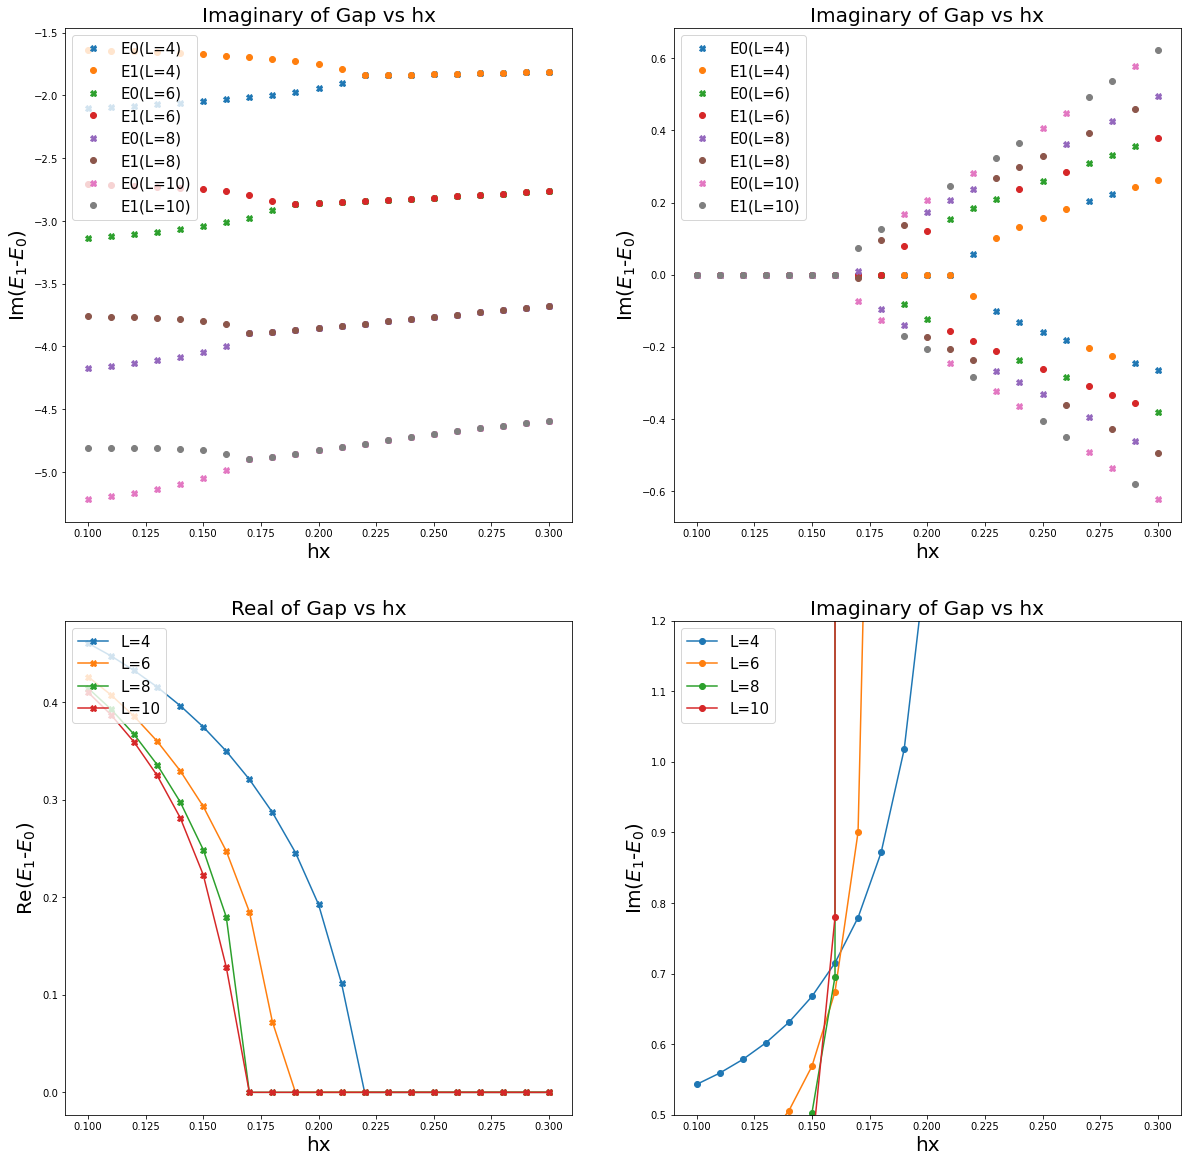

In [58]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
for l in range(len(Llist)):
    L = Llist[l]
    ax[1][0].plot(hx[:],Gap[l,:], "-X", label = "L=%d" %L)
    ax[1][0].set_title("Real of Gap vs hx", fontsize = 20)
    ax[1][0].set_ylabel("Re($E_1$-$E_0$)", fontsize = 20)
    ax[1][0].set_xlabel("hx", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    ax[0][0].plot(hx[:],np.real(E0[l,:]), "X", label = "E0(L=%d)" %L)
    ax[0][0].plot(hx[:],np.real(E1[l,:]), "o", label = "E1(L=%d)" %L)
    ax[0][0].set_title("Imaginary of Gap vs hx", fontsize = 20)
    ax[0][0].set_ylabel("Im($E_1$-$E_0$)", fontsize = 20)
    ax[0][0].set_xlabel("hx", fontsize = 20)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    ax[0][1].plot(hx[:],np.imag(E0[l,:]), "X", label = "E0(L=%d)" %L)
    ax[0][1].plot(hx[:],np.imag(E1[l,:]), "o", label = "E1(L=%d)" %L)
    ax[0][1].set_title("Imaginary of Gap vs hx", fontsize = 20)
    ax[0][1].set_ylabel("Im($E_1$-$E_0$)", fontsize = 20)
    ax[0][1].set_xlabel("hx", fontsize = 20)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    ax[1][1].plot(hx[:],lamda[l,:], "-o", label = "L=%d" %L)
    ax[1][1].set_title("Imaginary of Gap vs hx", fontsize = 20)
    ax[1][1].set_ylabel("Im($E_1$-$E_0$)", fontsize = 20)
    ax[1][1].set_xlabel("hx", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)
    ax[1][1].set_ylim([0.5,1.2])
    
plt.show()

## Real Hamiltoian Using Sparse

### Calculation ( complete by 16 min 45 s )

In [59]:
Llist = np.linspace(4,18,(18-4)//2 + 1,dtype = int)
print(Llist)
hz = np.linspace(0,1,51)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    L = Llist[l]
    print("L:",L)
    entropy.append(np.zeros((L+1,len(hz))))
    entropy_tensor.append(np.zeros((L+1,len(hz))))
    for hz_i in range(len(hz)):

        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,0,hz[hz_i])
        ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
        ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")

        index = np.argsort(ee)
        ee = sorted(ee)

        E0[l,hz_i] = ee[0]/L
        E1[l,hz_i] = ee[1]/L
        gap[l,hz_i] = ee[1] - ee[0]
        lamda[l,hz_i] = 1/gap[l,hz_i]/L
        SzE[l,hz_i] = Sv[:,index[0]] @ Szlist[0] @ Sv[:,index[0]] 
        SxE[l,hz_i] = Svx[:,index[0]] @ Sxlist[0] @ Svx[:,index[0]] 

        Na = np.linspace(0,L,L+1,dtype = int)
        for na in range(len(Na)):
            rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
            s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

            # # 用來把基態 reshape 成 (2,2,2,2...)
            # tensorshape = []
            # for L_i in range(L):
            #     tensorshape.append(2)
            # # 紀錄要接的index
            # dotAxes = np.linspace(0,L-1,L,dtype=int)
            # dotAxes=dotAxes[na:L]
            # # print(dotAxes)
            # if((na == 0) | (na == L+1)):
            #     entropy_tensor[l][na,hz_i] = 0
            # else:
            #     # 接完之後要 reshape 回一隻腳
            #     Ashape = (2**(na),2**((na)))
            #     eigntensor = np.reshape(Sv[:,0],tensorshape)
            #     eigntensor1 = np.copy(eigntensor)
            #     Atensor = np.reshape(np.tensordot(eigntensor,eigntensor1,axes=(dotAxes,dotAxes)),Ashape)
            #     singVlue, singVec = la.eigh(Atensor)
            #     for svalue in singVlue:
            #         entropy_tensor[l][na,hz_i] = entropy_tensor[l][na,hz_i] - np.abs(svalue)*np.log(np.abs(svalue))

            for svalue in s:
                entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)


[ 4  6  8 10 12 14 16 18]
L: 4
L: 6
L: 8
L: 10
L: 12
L: 14
L: 16
L: 18


### Data Plot

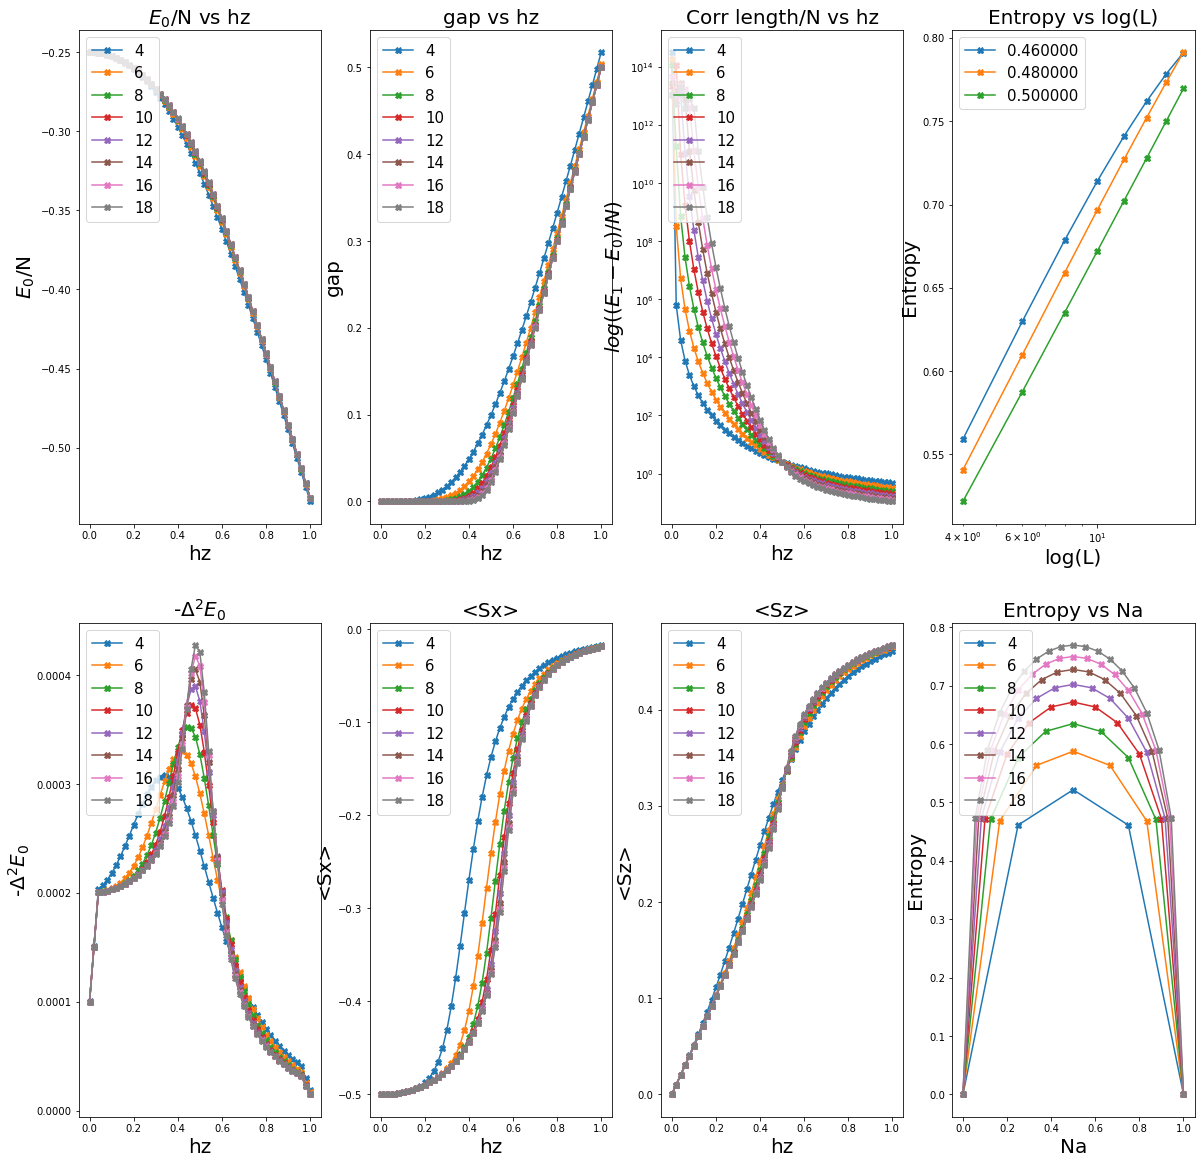

In [60]:
fig, ax = plt.subplots(2,4,figsize=(20,20))
entropyForAsize = np.zeros((len(Llist),len(hz)))
entropyForAsize1 = np.zeros((len(Llist),len(hz)))
for l in range(len(Llist)):
    L = Llist[l]
    ax[0][0].plot(hz[:],E0[l,:], "-X", label = "%d" %L)
    ax[0][0].set_title("$E_0$/N vs hz", fontsize = 20)
    ax[0][0].set_ylabel("$E_0$/N", fontsize = 20)
    ax[0][0].set_xlabel("hz", fontsize = 20)
    ax[0][0].legend(loc = "upper left", fontsize=15)

    ax[0][1].plot(hz[:],gap[l,:], "-X", label = "%d" %L)
    ax[0][1].set_title("gap vs hz", fontsize = 20)
    ax[0][1].set_ylabel("gap", fontsize = 20)
    ax[0][1].set_xlabel("hz", fontsize = 20)
    ax[0][1].legend(loc = "upper left", fontsize=15)

    ax[0][2].plot(hz[:],lamda[l,:], "-X", label = "%d" %L)
    ax[0][2].set_title("Corr length/N vs hz", fontsize = 20)
    ax[0][2].legend(loc = "upper left", fontsize=15)
    ax[0][2].set_ylabel("$log((E_1-E_0)/N)$", fontsize = 20)
    ax[0][2].set_xlabel("hz", fontsize = 20)
    ax[0][2].set_yscale('log')

    ax[1][0].plot(hz[:], -np.gradient(np.gradient(E0[l,:])), "-X", label = "%d" %L)
    ax[1][0].set_title("-$\Delta^2E_0$", fontsize = 20)
    ax[1][0].set_ylabel("-$\Delta^2E_0$", fontsize = 20)
    ax[1][0].set_xlabel("hz", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

    ax[1][1].plot(hz[:], SxE[l,:], "-X", label = "%d" %L)
    ax[1][1].set_title("<Sx>", fontsize = 20)
    ax[1][1].set_ylabel("<Sx>", fontsize = 20)
    ax[1][1].set_xlabel("hz", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

    ax[1][2].plot(hz[:], SzE[l,:], "-X", label = "%d" %L)
    ax[1][2].set_title("<Sz>", fontsize = 20)
    ax[1][2].set_ylabel("<Sz>", fontsize = 20)
    ax[1][2].set_xlabel("hz", fontsize = 20)
    ax[1][2].legend(loc = "upper left", fontsize=15)

    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]
    # for h in range(len(hz)):
    #     entropyForAsize1[l,h] = entropy1[l][Llist[l]//2,h]


for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][3].plot(Llist[:],entropyForAsize[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][3].set_ylabel("Entropy", fontsize = 20)
        ax[0][3].set_xlabel("log(L)", fontsize = 20)
        ax[0][3].set_title("Entropy vs log(L)", fontsize = 20)
        ax[0][3].legend(loc = "upper left", fontsize=15)
        ax[0][3].set_xscale('log')
    
# for l in range(len(Llist)):
#     Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
#     ax[1][3].plot(Na[:],entropy[l][:,(len(hz)+1)//2], "-X", label = "%d" %(Llist[l]))
#     ax[1][3].set_ylabel("Entropy", fontsize = 20)
#     ax[1][3].set_xlabel("Na", fontsize = 20)
#     ax[1][3].set_title("Entropy vs Na", fontsize = 20)
#     ax[1][3].legend(loc = "upper left", fontsize=15)

for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][3].plot(SNa[:],entropy[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
    ax[1][3].set_ylabel("Entropy", fontsize = 20)
    ax[1][3].set_xlabel("Na", fontsize = 20)
    ax[1][3].set_title("Entropy vs Na", fontsize = 20)
    ax[1][3].legend(loc = "upper left", fontsize=15)


plt.show()

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


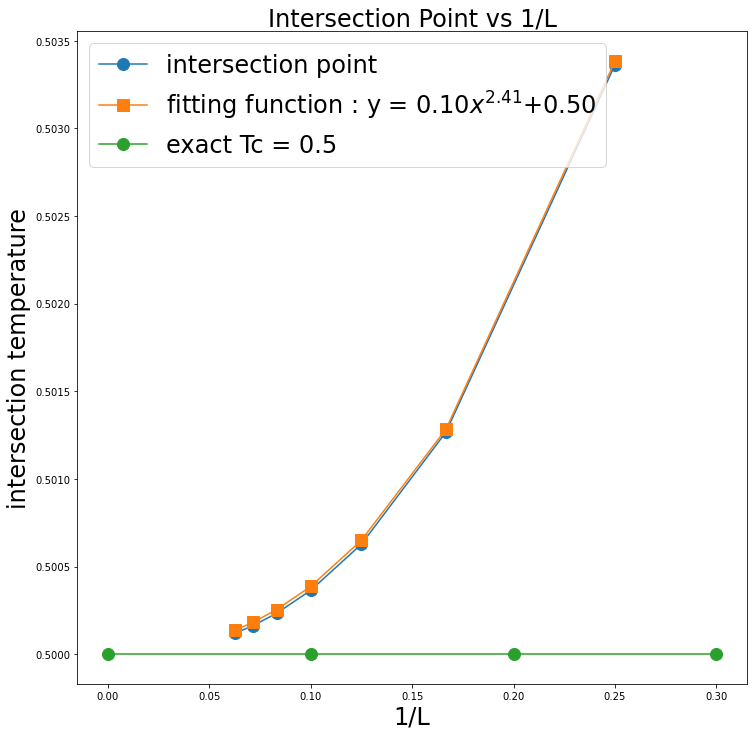

In [61]:
Linverse = [(1/i) for i in range (4,18,2)]
hzlist = [i for i in range (20,30)]

hc = np.zeros(len(Llist)-1)
print(hzlist)

# for i in range(len(Llist)):
#     plt.plot(hzlist[:],lamda[i,hzlist[:]])
plt.figure(figsize=(12,12))
for i in range(len(Llist)-1):
    for hz_i in hzlist:
        if((lamda[i+1,hz_i] - lamda[i,hz_i])*(lamda[i+1,hz_i+1] - lamda[i,hz_i+1]) < 0):
            p1 = np.polyfit([hz[hz_i],hz[hz_i+1]],[lamda[i,hz_i],lamda[i,hz_i+1]],1)
            p2 = np.polyfit([hz[hz_i],hz[hz_i+1]],[lamda[i+1,hz_i],lamda[i+1,hz_i+1]],1)
            hc[i] = np.roots(p1 -p2)

def func(x, a, b, c):
    return a * x ** b + c

popt, pcov = curve_fit(func, Linverse, hc, maxfev=40000)
y = func(Linverse,*popt) +0.00002


plt.plot(Linverse[:],hc[:],"-o", markersize = 12, label = "intersection point")
plt.plot(Linverse[:],y[:],"-s", markersize = 12, label = "fitting function : y = %.2f$x^{%.2f}$+%.2f" %(popt[0],popt[1],popt[2]))
plt.plot([0,0.1,0.2,0.3],[0.5,0.5,0.5,0.5],"-o", markersize = 12, label = "exact Tc = 0.5")
plt.title("Intersection Point vs 1/L",fontsize = 24)
plt.xlabel("1/L",fontsize = 24)
plt.ylabel("intersection temperature",fontsize = 24)
plt.legend(loc = "best", fontsize = 24)

### Tensor Method Comparison 5 m 56 s

In [62]:
Llist = np.linspace(4,12,(12-4)//2 + 1,dtype = int)
print(Llist)
hz = np.linspace(0,1,51)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    L = Llist[l]
    print("L:",L)
    entropy.append(np.zeros((L+1,len(hz))))
    entropy_tensor.append(np.zeros((L+1,len(hz))))
    for hz_i in range(len(hz)):

        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,0,hz[hz_i])
        ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
        ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")

        index = np.argsort(ee)
        ee = sorted(ee)

        Na = np.linspace(0,L,L+1,dtype = int)
        for na in range(len(Na)):
            rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
            s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

            # 用來把基態 reshape 成 (2,2,2,2...)
            tensorshape = []
            for L_i in range(L):
                tensorshape.append(2)
            # 紀錄要接的index
            dotAxes = np.linspace(0,L-1,L,dtype=int)
            dotAxes=dotAxes[na:L]
            # print(dotAxes)
            if((na == 0) | (na == L+1)):
                entropy_tensor[l][na,hz_i] = 0
            else:
                # 接完之後要 reshape 回一隻腳
                Ashape = (2**(na),2**((na)))
                eigntensor = np.reshape(Sv[:,0],tensorshape)
                eigntensor1 = np.copy(eigntensor)
                Atensor = np.reshape(np.tensordot(eigntensor,eigntensor1,axes=(dotAxes,dotAxes)),Ashape)
                singVlue, singVec = la.eigh(Atensor)
                for svalue in singVlue:
                    entropy_tensor[l][na,hz_i] = entropy_tensor[l][na,hz_i] - np.abs(svalue)*np.log(np.abs(svalue))

            for svalue in s:
                entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)

[ 4  6  8 10 12]
L: 4
L: 6
L: 8
L: 10
L: 12


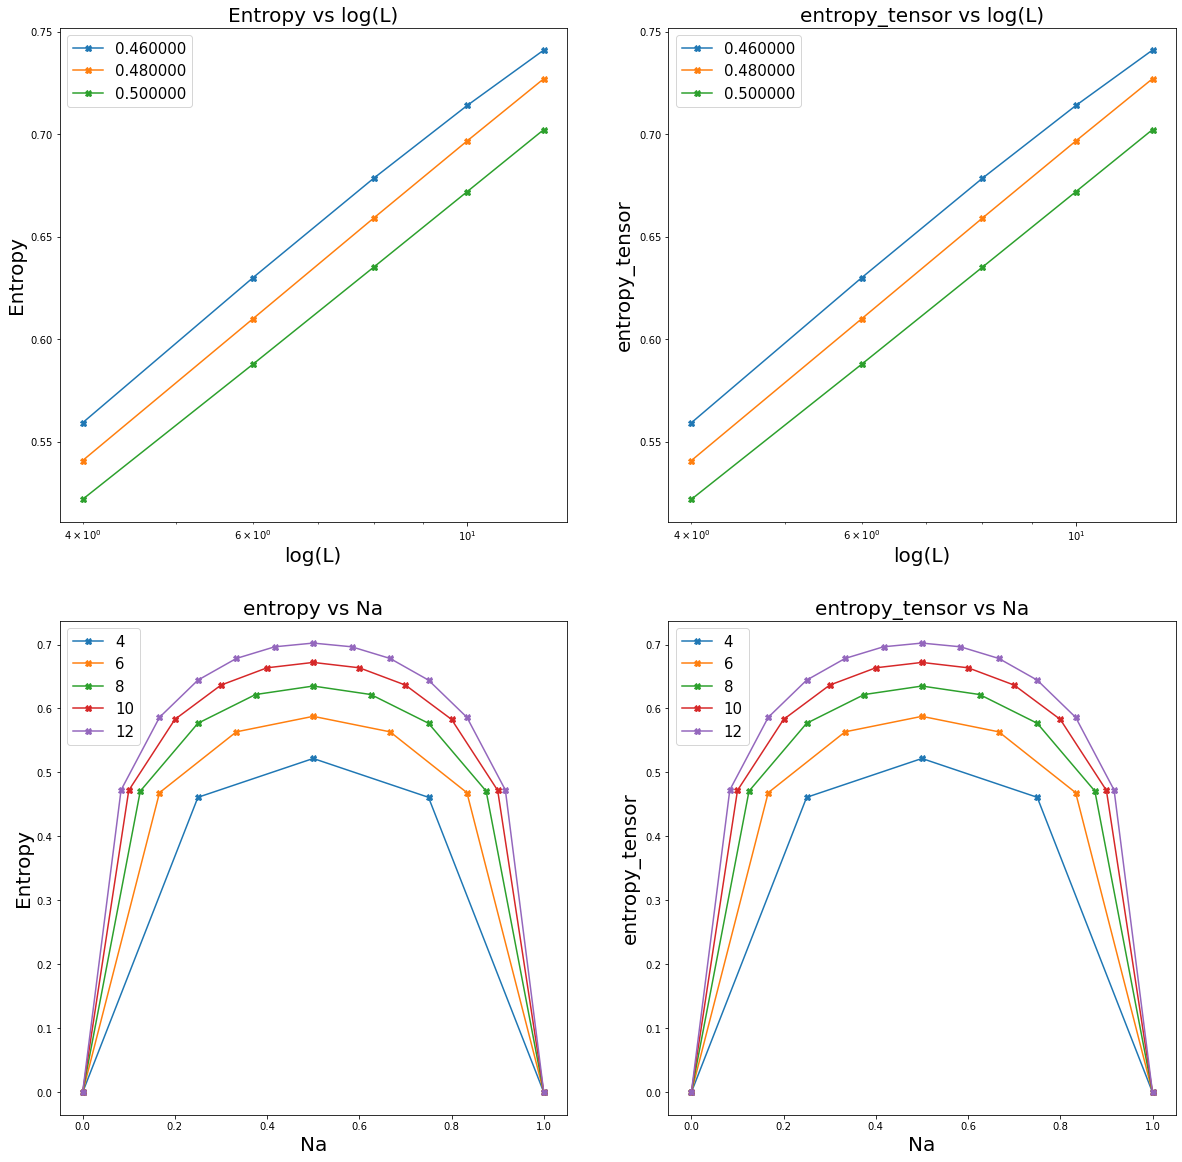

In [63]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
entropyForAsize = np.zeros((len(Llist),len(hz)))
entropyForAsize_tensor = np.zeros((len(Llist),len(hz)))
for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]
    for h in range(len(hz)):
        entropyForAsize_tensor[l,h] = entropy_tensor[l][Llist[l]//2,h]

for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][0].plot(Llist[:],entropyForAsize[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][0].set_ylabel("Entropy", fontsize = 20)
        ax[0][0].set_xlabel("log(L)", fontsize = 20)
        ax[0][0].set_title("Entropy vs log(L)", fontsize = 20)
        ax[0][0].legend(loc = "upper left", fontsize=15)
        ax[0][0].set_xscale('log')

for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][1].plot(Llist[:],entropyForAsize_tensor[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][1].set_ylabel("entropy_tensor", fontsize = 20)
        ax[0][1].set_xlabel("log(L)", fontsize = 20)
        ax[0][1].set_title("entropy_tensor vs log(L)", fontsize = 20)
        ax[0][1].legend(loc = "upper left", fontsize=15)
        ax[0][1].set_xscale('log')

for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][0].plot(SNa[:],entropy[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
    ax[1][0].set_ylabel("Entropy", fontsize = 20)
    ax[1][0].set_xlabel("Na", fontsize = 20)
    ax[1][0].set_title("entropy vs Na", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][1].plot(SNa[:],entropy_tensor[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
    ax[1][1].set_ylabel("entropy_tensor", fontsize = 20)
    ax[1][1].set_xlabel("Na", fontsize = 20)
    ax[1][1].set_title("entropy_tensor vs Na", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

In [142]:
Llist = np.linspace(4,8,(8-4)//2 + 1,dtype = int)
print(Llist)
hz = np.linspace(0,1,51)
E0 = np.zeros((len(Llist),len(hz)))
E1 = np.zeros((len(Llist),len(hz)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy_tensor1 = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hz)))
lamda = np.zeros((len(Llist),len(hz)))
SzE = np.zeros((len(Llist),len(hz)))
SxE = np.zeros((len(Llist),len(hz)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    size = Llist[l]
    print("size:",size)
    entropy_tensor1.append(np.zeros((size+1,len(hz))))
    entropy_tensor.append(np.zeros((size+1,len(hz))))
    for hz_i in range(len(hz)):

        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(size,sparseSx,sparseSy,sparseSz,sparseI,1,0,hz[hz_i])
        ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
        ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")

        index = np.argsort(ee)
        ee = sorted(ee)
        
        eeR, Sv_R = sparse.linalg.eigs(SHtot,which="SR")
        SHtot_dagger = SHtot.conjugate().transpose()
        eeL, Sv_L = sparse.linalg.eigs(SHtot_dagger,which="SR")
        phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]
        print("phase:", phase)
        L0 = np.copy(Sv_L[:,0]/phase)
        R = np.copy(Sv_R[:,0])
        L = np.copy(Sv_L[:,0])

        Na = np.linspace(0,size,size+1,dtype = int)
        for na in range(len(Na)):
            # rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
            # s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

            # 用來把基態 reshape 成 (2,2,2,2...)
            tensorshape = []
            for L_i in range(size):
                tensorshape.append(2)
            # 紀錄要接的index
            dotAxes = np.linspace(0,size-1,size,dtype=int)
            dotAxes=dotAxes[na:size]
            # print(dotAxes)
            if((na == 0) | (na == size)):
                print("na:",na)
                entropy_tensor[l][na,hz_i] = 0
            else:
                # 接完之後要 reshape 回一隻腳
                Ashape = (2**(na),2**((na)))
                eigntensor = np.reshape(Sv[:,0],tensorshape)
                eigntensor1 = np.copy(eigntensor)
                eigntensorR = np.reshape(R,tensorshape)
                eigntensorL = np.reshape(L,tensorshape)
                Atensor = np.reshape(np.tensordot(eigntensor,eigntensor1,axes=(dotAxes,dotAxes)),Ashape)
                Atensor1 = np.reshape(np.tensordot(eigntensorR,eigntensorL,axes=(dotAxes,dotAxes)),Ashape)
                singVlue, singVec = la.eigh(Atensor)
                singVlue1, singVec1 = la.eigh(Atensor1)
                for svalue in singVlue:
                    entropy_tensor[l][na,hz_i] = entropy_tensor[l][na,hz_i] - np.abs(svalue)*np.log(np.abs(svalue))
                for svalue in singVlue1:
                    entropy_tensor1[l][na,hz_i] = entropy_tensor1[l][na,hz_i] - np.abs(svalue)*np.log(np.abs(svalue))

            # for svalue in s:
            #     entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)

[4 6 8]
size: 4
phase: (0.03834280305876403+0j)
na: 0
na: 4
phase: (1+0j)
na: 0
na: 4
phase: (-5.774565022281386e-11+0j)
na: 0
na: 4
phase: (3.9411154596990165e-12+0j)
na: 0
na: 4
phase: (1.0000000000000002+0j)
na: 0
na: 4
phase: (-1+0j)
na: 0
na: 4
phase: (-1+0j)
na: 0
na: 4
phase: (6.636114340844609e-13+0j)
na: 0
na: 4
phase: (0.9999999999999999+0j)
na: 0
na: 4
phase: (-6.601497695565709e-13+0j)
na: 0
na: 4
phase: (1+0j)
na: 0
na: 4
phase: (1+0j)
na: 0
na: 4
phase: (-1.7921600123215264e-14+0j)
na: 0
na: 4
phase: (-2.985215811903865e-14+0j)
na: 0
na: 4
phase: (-5.438514725995368e-14+0j)
na: 0
na: 4
phase: (1.3186212446910417e-14+0j)
na: 0
na: 4
phase: (-1.0000000000000007+0j)
na: 0
na: 4
phase: (0.9999999999999998+0j)
na: 0
na: 4
phase: (-1.0000000000000004+0j)
na: 0
na: 4
phase: (-0.9999999999999998+0j)
na: 0
na: 4
phase: (-1.0000000000000002+0j)
na: 0
na: 4
phase: (-0.9999999999999998+0j)
na: 0
na: 4
phase: (1.0000000000000002+0j)
na: 0
na: 4
phase: (1+0j)
na: 0
na: 4
phase: (1.0000

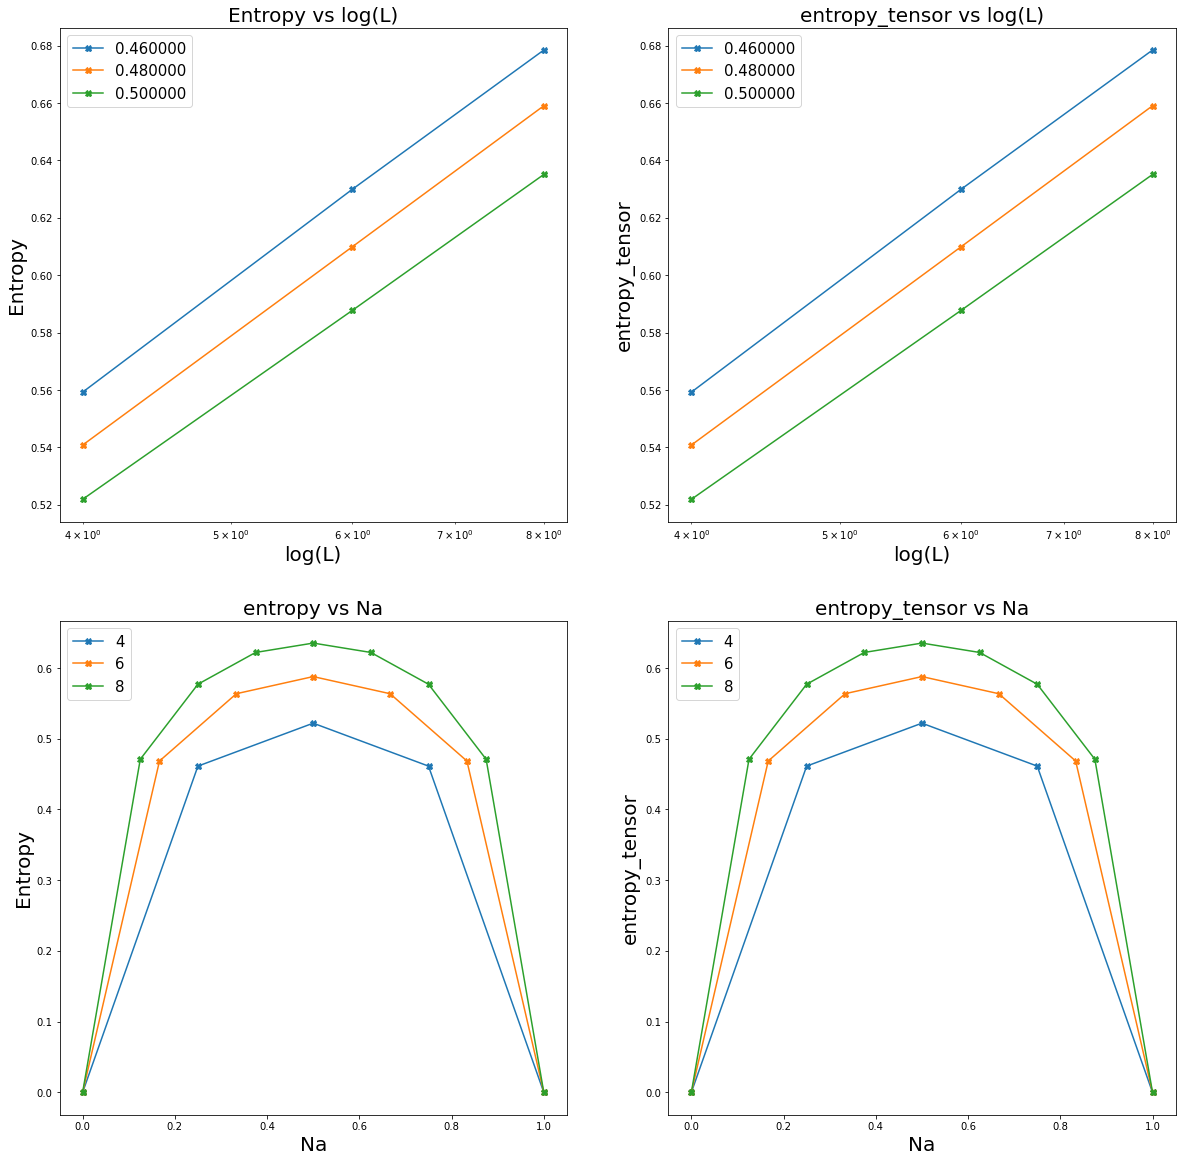

In [143]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
entropyForAsize = np.zeros((len(Llist),len(hz)))
entropyForAsize_tensor = np.zeros((len(Llist),len(hz)))
for l in range(len(Llist)):
    L = Llist[l]
    for h in range(len(hz)):
        entropyForAsize[l,h] = entropy_tensor[l][Llist[l]//2,h]
    for h in range(len(hz)):
        entropyForAsize_tensor[l,h] = entropy_tensor1[l][Llist[l]//2,h]

for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][0].plot(Llist[:],entropyForAsize[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][0].set_ylabel("Entropy", fontsize = 20)
        ax[0][0].set_xlabel("log(L)", fontsize = 20)
        ax[0][0].set_title("Entropy vs log(L)", fontsize = 20)
        ax[0][0].legend(loc = "upper left", fontsize=15)
        ax[0][0].set_xscale('log')

for hz_i in range(len(hz[0:(len(hz)+1)//2])):
    if(hz_i >= (len(hz)-1)//2 - 2):
        ax[0][1].plot(Llist[:],entropyForAsize_tensor[:,hz_i], "-X", label = "%f" %(hz[hz_i]))
        ax[0][1].set_ylabel("entropy_tensor", fontsize = 20)
        ax[0][1].set_xlabel("log(L)", fontsize = 20)
        ax[0][1].set_title("entropy_tensor vs log(L)", fontsize = 20)
        ax[0][1].legend(loc = "upper left", fontsize=15)
        ax[0][1].set_xscale('log')

for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][0].plot(SNa[:],entropy_tensor[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
    ax[1][0].set_ylabel("Entropy", fontsize = 20)
    ax[1][0].set_xlabel("Na", fontsize = 20)
    ax[1][0].set_title("entropy vs Na", fontsize = 20)
    ax[1][0].legend(loc = "upper left", fontsize=15)

for l in range(len(Llist)):
    Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
    SNa = []
    for i in range(len(Na)):
        SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
    ax[1][1].plot(SNa[:],entropy_tensor1[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
    ax[1][1].set_ylabel("entropy_tensor", fontsize = 20)
    ax[1][1].set_xlabel("Na", fontsize = 20)
    ax[1][1].set_title("entropy_tensor vs Na", fontsize = 20)
    ax[1][1].legend(loc = "upper left", fontsize=15)

In [ ]:
entropy_tensor[]

## Complex Hamiltonian using sparse

### Calculation 8 min 35 s

In [64]:
Llist = np.linspace(4,18,(18-4)//2+1,dtype = int)
print(Llist)
hx = np.linspace(0.1,0.25,31)
E0 = np.zeros((len(Llist),len(hx)),dtype=complex)
E1 = np.zeros((len(Llist),len(hx)),dtype=complex)
imGap = np.zeros((len(Llist),len(hx)))
lamda = np.zeros((len(Llist),len(hx)))
Gap = np.zeros((len(Llist),len(hx)))



for l in range(len(Llist)):
    L = Llist[l]
    for hx_i in range(len(hx)):
        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,hx[hx_i],0.2)
        ee, Sv = sparse.linalg.eigs(SHtot)
        ee= np.sort_complex(ee)
        E0[l,hx_i] = ee[0]
        E1[l,hx_i] = ee[1]
        Gap[l,hx_i] = np.real(ee[1] - ee[0])
        imGap[l,hx_i] = np.imag(ee[1] - ee[0])
        lamda[l,hx_i] = 1/np.real(ee[1] - ee[0])/L

[ 4  6  8 10 12 14 16 18]


<ipython-input-64-cc6196a69579>:22: RuntimeWarning: divide by zero encountered in double_scalars
  lamda[l,hx_i] = 1/np.real(ee[1] - ee[0])/L


KeyboardInterrupt: 

### Data Plot

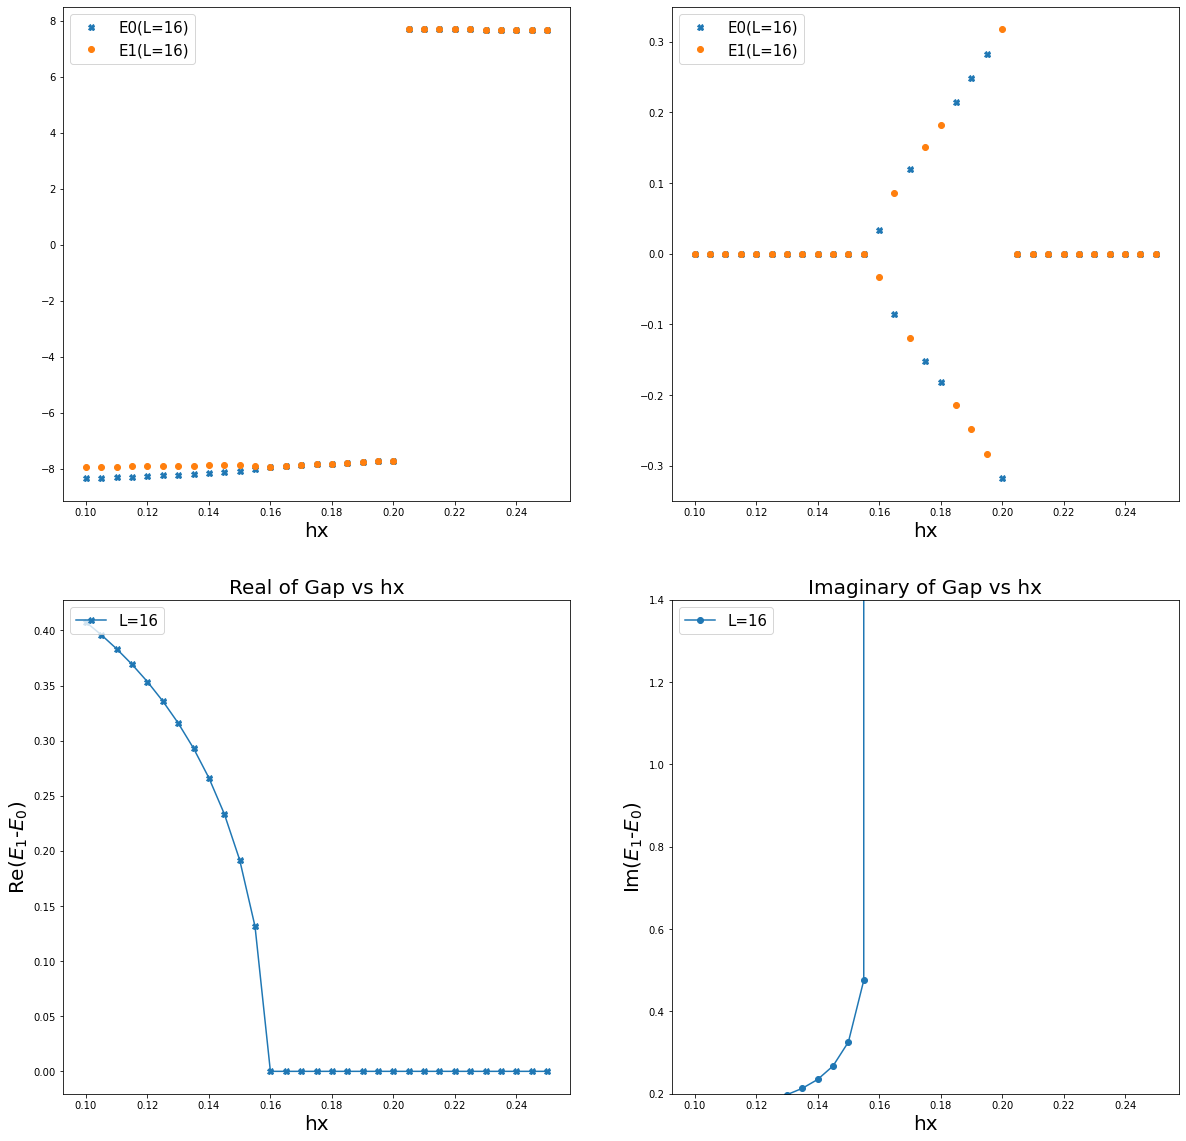

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
# for l in range(len(Llist)):
L = 16
ax[1][0].plot(hx[:],Gap[l,:], "-X", label = "L=%d" %L)
ax[1][0].set_title("Real of Gap vs hx", fontsize = 20)
ax[1][0].set_ylabel("Re($E_1$-$E_0$)", fontsize = 20)
ax[1][0].set_xlabel("hx", fontsize = 20)
ax[1][0].legend(loc = "upper left", fontsize=15)

ax[0][0].plot(hx[:],np.real(E0[l,:]), "X", label = "E0(L=%d)" %L)
ax[0][0].plot(hx[:],np.real(E1[l,:]), "o", label = "E1(L=%d)" %L)
# ax[0][0].set_title("Imaginary of Gap vs hx", fontsize = 20)
# ax[0][0].set_ylabel("Im($E_1$-$E_0$)", fontsize = 20)
ax[0][0].set_xlabel("hx", fontsize = 20)
ax[0][0].legend(loc = "upper left", fontsize=15)

ax[0][1].plot(hx[:],np.imag(E0[l,:]), "X", label = "E0(L=%d)" %L)
ax[0][1].plot(hx[:],np.imag(E1[l,:]), "o", label = "E1(L=%d)" %L)
# ax[0][1].set_title("Imaginary of Gap vs hx", fontsize = 20)
# ax[0][1].set_ylabel("Im($E_1$-$E_0$)", fontsize = 20)
ax[0][1].set_xlabel("hx", fontsize = 20)
ax[0][1].legend(loc = "upper left", fontsize=15)

ax[1][1].plot(hx[:],lamda[l,:], "-o", label = "L=%d" %L)
ax[1][1].set_title("Imaginary of Gap vs hx", fontsize = 20)
ax[1][1].set_ylabel("Im($E_1$-$E_0$)", fontsize = 20)
ax[1][1].set_xlabel("hx", fontsize = 20)
ax[1][1].legend(loc = "upper left", fontsize=15)
ax[1][1].set_ylim([0.2,1.4])
    
plt.show()

## Seeking Phase ( 注意複數、要取 conjugate )

### Nearly Hermitian Hamiltionian

In [18]:
Htot, ztot, zlist, xtot, xlist = Hamiltonain(4, Sx, Sy, Sz, I, 1, 10**2, 0.5)
print(type(Htot[0,0]))
ee, v_R = la.eig(Htot)
Htot_dagger = Htot.conjugate().transpose()
ee, v_L = la.eig(Htot)
phase = v_R[:,0].conjugate() @ v_L[:,0]

L0 = np.copy(v_L[:,0]/phase)
R = np.copy(v_R[:,0])
L = np.copy(v_L[:,0])

print(L.conjugate() @ R)
print(L0.conjugate() @ R)

print(np.shape(R))
print(np.shape(L0))

rho_RL0 = np.tensordot(R,L0.conjugate(),0)
rho_RR = np.tensordot(R,R.conjugate(),0)

print(np.shape(rho_RL0))
print(np.shape(rho_RR))


print(np.trace(rho_RL0))
print(np.trace(rho_RR))

<class 'numpy.complex128'>
(0.9999999999999999+0j)
(1.0000000000000004+0j)
(16,)
(16,)
(16, 16)
(16, 16)
(1.0000000000000002-3.3055584032980065e-19j)
(0.9999999999999998+2.0806419359348921e-19j)


In [23]:
Htot, ztot, zlist, xtot, xlist = Hamiltonain(4, Sx, Sy, Sz, I, 1, 10**6, 0.2)
print(type(Htot[0,0]))
ee, v_R = la.eig(Htot)
Htot_dagger = Htot.conjugate().transpose()
ee, v_L = la.eig(Htot)
phase = v_R[:,0].conjugate() @ v_L[:,0]
print(phase)
L0 = np.copy(v_L[:,0]/phase)
R = np.copy(v_R[:,0])
L = np.copy(v_L[:,0])

print(L.conjugate() @ R)
print(L0.conjugate() @ R)

print(np.shape(R))
print(np.shape(L0))

rho_RL0 = np.tensordot(R,L0.conjugate(),0)
rho_RR = np.tensordot(R,R.conjugate(),0)

print(np.shape(rho_RL0))
print(np.shape(rho_RR))


print(np.trace(rho_RL0))
print(np.trace(rho_RR))

<class 'numpy.complex128'>
(1.0000000000000004-8.135647901824992e-26j)
(1.0000000000000004+0j)
(0.9999999999999999-5.293955920339377e-23j)
(16,)
(16,)
(16, 16)
(16, 16)
(0.9999999999999998-7.024780358566143e-24j)
(1.0000000000000002-8.055023505673053e-24j)


### Nearly Hermitian Hamiltionian

In [43]:
SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(4, sparseSx, sparseSy, sparseSz, sparseI, 1, 10**-10, 0.5)

ee, Sv_R = sparse.linalg.eigsh(SHtot,which="SR")
SHtot_dagger = SHtot.conjugate().transpose()
ee, Sv_L = sparse.linalg.eigsh(SHtot_dagger,which="SR")
phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]

L0 = np.copy(Sv_L[:,0]/phase)
R = np.copy(Sv_R[:,0])
L = np.copy(Sv_L[:,0])

print(L.conjugate() @ R)
print(L0.conjugate() @ R)

rho_RL = np.tensordot(R,L.conjugate(),0)
rho_RL0 = np.tensordot(R,L0.conjugate(),0)
rho_RR = np.tensordot(R,R.conjugate(),0)

print(np.shape(rho_RL0))
print(np.shape(rho_RR))

print("Sv_R[:,0].conjugate() @ Sv_R[:,0]",Sv_R[:,0].conjugate() @ Sv_R[:,0])
print("np.trace(rho_RL)",np.trace(rho_RL))
print("np.trace(rho_RL0)",np.trace(rho_RL0))
print("np.trace(rho_RR)",np.trace(rho_RR))

(2.2840327211713863e-14-8.291039385853406e-15j)
(1.000000000001819-1.4551915228366852e-11j)
(16, 16)
(16, 16)
Sv_R[:,0].conjugate() @ Sv_R[:,0] (0.9999999999999998+0j)
np.trace(rho_RL) (2.2840327211610466e-14-8.291039386215297e-15j)
np.trace(rho_RL0) (1.0000000000009095-2.1827872842550278e-11j)
np.trace(rho_RR) (0.9999999999999998+2.016958754397184e-17j)


### NomHermitian Hamiltionian

In [64]:
SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(4, sparseSx, sparseSy, sparseSz, sparseI, 1, 10, 0.1)
ee, Sv_R = sparse.linalg.eigs(SHtot,which="SR")
SHtot_dagger = SHtot.conjugate().transpose()
ee, Sv_L = sparse.linalg.eigs(SHtot_dagger,which="SR")
phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]

L0 = np.copy(Sv_L[:,0]/phase)
R = np.copy(Sv_R[:,0])
L = np.copy(Sv_L[:,0])

print(R.conjugate() @ L)
print(R.conjugate() @ L0)


# R = np.copy(R.reshape([16]))
# L0 = np.copy(L0.reshape([16]))
# L = np.copy(L.reshape([16]))

# print(np.shape(R))
# print(np.shape(L0))

rho_RL = np.tensordot(R,L.conjugate(),0)
rho_RL0 = np.tensordot(R,L0.conjugate(),0)
rho_RR = np.tensordot(R,R.conjugate(),0)

# print(np.shape(rho_RL))
# print(np.shape(rho_RL))
print("Sv_R[:,0].conjugate() @ Sv_R[:,0]",Sv_R[:,0].conjugate() @ Sv_R[:,0])
print("np.trace(rho_RL)",np.trace(rho_RL))
print("np.trace(rho_RL0)",np.trace(rho_RL0))
print("np.trace(rho_RR)",np.trace(rho_RR))

(0.9997045115348184+0.014100725226090516j)
(1+0j)
Sv_R[:,0].conjugate() @ Sv_R[:,0] (1+0j)
np.trace(rho_RL) (0.9997045115348184-0.01410072522609049j)
np.trace(rho_RL0) (1+4.0766001685454967e-17j)
np.trace(rho_RR) (1+6.501061030044207e-18j)


In [ ]:
Llist = np.linspace(4,10,(10-4)//2 + 1,dtype = int)
print(Llist)
hx = np.linspace(0,1,11)
E0 = np.zeros((len(Llist),len(hx)))
E1 = np.zeros((len(Llist),len(hx)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hx)))
lamda = np.zeros((len(Llist),len(hx)))
SzE = np.zeros((len(Llist),len(hx)))
SxE = np.zeros((len(Llist),len(hx)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    Size = Llist[l]
    print("Size:",Size)
    # entropy.append(np.zeros((Size+1,len(hz))))
    entropy_tensor.append(np.zeros((Size+1,len(hx))))
    # for hx_i in range(len(hx)):



    SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(Size,sparseSx,sparseSy,sparseSz,sparseI,0.8,hx[hx_i],0.2)
    # ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
    # ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")

    eeR, Sv_R = sparse.linalg.eigs(SHtot,which="SR")
    SHtot_dagger = SHtot.conjugate().transpose()
    eeL, Sv_L = sparse.linalg.eigs(SHtot_dagger,which="SR")
    phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]
    print("phase:", phase)
    L0 = np.copy(Sv_L[:,0]/phase)
    R = np.copy(Sv_R[:,0])
    L = np.copy(Sv_L[:,0])

    rho_RL = np.tensordot(R,L.conjugate(),0)
    rho_RL0 = np.tensordot(R,L0.conjugate(),0)
    rho_RR = np.tensordot(R,R.conjugate(),0)

    # print("Sv_R[:,0].conjugate() @ Sv_R[:,0]",Sv_R[:,0].conjugate() @ Sv_R[:,0])
    # print("np.trace(rho_RL)",np.trace(rho_RL))
    # print("np.trace(rho_RL0)",np.trace(rho_RL0))
    # print("np.trace(rho_RR)",np.trace(rho_RR))

    Na = np.linspace(0,Size,Size+1,dtype = int)
    print(Na)
    for na in range(len(Na)):
        # rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
        # s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

        # 用來把基態 reshape 成 (2,2,2,2...)
        tensorshape = []
        for L_i in range(Size):
            tensorshape.append(2)
        # 紀錄要接的index
        dotAxes = np.linspace(0,Size-1,Size,dtype=int)
        dotAxes=dotAxes[na:Size]
        # print(dotAxes)
        if((na == 0) | (na == Size)):
            print("na:",na)
            entropy_tensor[l][na,hx_i] = 0
        else:
            # 接完之後要 reshape 回一隻腳
            Ashape = (2**(na),2**((na)))
            eigntensorR = np.reshape(R,tensorshape)
            eigntensorL0 = np.reshape(L0,tensorshape)
            Atensor = np.reshape(np.tensordot(eigntensorR,eigntensorL0,axes=(dotAxes,dotAxes)),Ashape)
            singVlue, singVec = la.eig(Atensor)
            for svalue in singVlue:
                entropy_tensor[l][na,hx_i] = entropy_tensor[l][na,hx_i] - np.real(svalue)*np.log(np.abs(svalue))

In [144]:
print(eeR)
print(eeL)

[-4.25454112+0.j -3.75381319+0.j -3.51700031+0.j -3.51700031+0.j
 -3.13577921+0.j -3.13577921+0.j]
[-4.25454112+0.j -3.75381319+0.j -3.51700031+0.j -3.51700031+0.j
 -3.13577921+0.j -3.13577921+0.j]


### NomHermitian Rainbow

In [129]:
Llist = np.linspace(4,10,(10-4)//2 + 1,dtype = int)
print(Llist)
hx = np.linspace(0,1,11)
E0 = np.zeros((len(Llist),len(hx)))
E1 = np.zeros((len(Llist),len(hx)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hx)))
lamda = np.zeros((len(Llist),len(hx)))
SzE = np.zeros((len(Llist),len(hx)))
SxE = np.zeros((len(Llist),len(hx)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    Size = Llist[l]
    print("Size:",Size)
    # entropy.append(np.zeros((Size+1,len(hz))))
    entropy_tensor.append(np.zeros((Size+1,len(hx))))
    for hx_i in range(len(hx)):

        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(Size,sparseSx,sparseSy,sparseSz,sparseI,0.8,0,0.2)
        # ee, Sv = sparse.linalg.eigsh(SHtot,which="SA")
        # ex, Svx = sparse.linalg.eigsh(SHtot + 0.01*Sxtot,which="SA")

        eeR, Sv_R = sparse.linalg.eigs(SHtot,which="SR")
        SHtot_dagger = SHtot.conjugate().transpose()
        eeL, Sv_L = sparse.linalg.eigs(SHtot_dagger,which="SR")
        phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]
        print("phase:", phase)
        L0 = np.copy(Sv_L[:,0]/phase)
        R = np.copy(Sv_R[:,0])
        L = np.copy(Sv_L[:,0])

        rho_RL = np.tensordot(R,L.conjugate(),0)
        rho_RL0 = np.tensordot(R,L0.conjugate(),0)
        rho_RR = np.tensordot(R,R.conjugate(),0)

        # print("Sv_R[:,0].conjugate() @ Sv_R[:,0]",Sv_R[:,0].conjugate() @ Sv_R[:,0])
        # print("np.trace(rho_RL)",np.trace(rho_RL))
        # print("np.trace(rho_RL0)",np.trace(rho_RL0))
        # print("np.trace(rho_RR)",np.trace(rho_RR))

        Na = np.linspace(0,Size,Size+1,dtype = int)
        print(Na)
        for na in range(len(Na)):
            # rv = np.reshape(Sv[:,0], (2**Na[na],2**(L-Na[na])))
            # s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

            # 用來把基態 reshape 成 (2,2,2,2...)
            tensorshape = []
            for L_i in range(Size):
                tensorshape.append(2)
            # 紀錄要接的index
            dotAxes = np.linspace(0,Size-1,Size,dtype=int)
            dotAxes=dotAxes[na:Size]
            # print(dotAxes)
            if((na == 0) | (na == Size)):
                print("na:",na)
                entropy_tensor[l][na,hx_i] = 0
            else:
                # 接完之後要 reshape 回一隻腳
                Ashape = (2**(na),2**((na)))
                eigntensorR = np.reshape(R,tensorshape)
                eigntensorL0 = np.reshape(L0,tensorshape)
                Atensor = np.reshape(np.tensordot(eigntensorR,eigntensorL0,axes=(dotAxes,dotAxes)),Ashape)
                singVlue, singVec = la.eig(Atensor)
                for svalue in singVlue:
                    entropy_tensor[l][na,hx_i] = entropy_tensor[l][na,hx_i] - np.real(svalue)*np.log(np.abs(svalue))

            # for svalue in s:
            #     entropy[l][na,hz_i] = entropy[l][na,hz_i] - (svalue)*(svalue)*np.log(svalue*svalue)

[ 4  6  8 10]
Size: 4
phase: (-1.0000000000000002+0j)
[0 1 2 3 4]
na: 0
na: 4
phase: (-4.354155924701786e-16-2.706168622523819e-16j)
[0 1 2 3 4]
na: 0
na: 4
phase: (-8.673617379884035e-19-2.411265631607762e-16j)
[0 1 2 3 4]
na: 0
na: 4
phase: (1.2880321809127793e-15-1.186550857568136e-15j)
[0 1 2 3 4]
na: 0
na: 4
phase: (-2.411265631607762e-16-6.357761539454998e-16j)
[0 1 2 3 4]
na: 0
na: 4
phase: (0.7190799841927437-0.657771883831161j)
[0 1 2 3 4]
na: 0
na: 4
phase: (-2.445960101127298e-16-2.463307335887066e-16j)
[0 1 2 3 4]
na: 0
na: 4
phase: (2.480654570646834e-16-3.686287386450715e-16j)
[0 1 2 3 4]
na: 0
na: 4
phase: (-0.1922517624551925+0.9506433680748936j)
[0 1 2 3 4]
na: 0
na: 4
phase: (-6.635317295611287e-16-7.797582024515748e-16j)
[0 1 2 3 4]
na: 0
na: 4
phase: (0.7903177673309437+0.5644833346723255j)
[0 1 2 3 4]
na: 0
na: 4
Size: 6
phase: (-2.6171357947002026e-13+0j)
[0 1 2 3 4 5 6]
na: 0
na: 6
phase: (1.8325185119349996e-15-4.012198559499858e-15j)
[0 1 2 3 4 5 6]
na: 0
na: 6

In [85]:
Size

10

In [76]:
np.linspace(0,Llist[3],Llist[3]+1,dtype = int)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [128]:
entropy_tensor[3][:,9]

array([0.        , 0.05739891, 0.05739074, 0.05739074, 0.05739074,
       0.05739074, 0.05739074, 0.05739074, 0.05739074, 0.05739891,
       0.        ])

In [72]:
print(entropy_tensor[l][:,49])

[ 0.         -0.06044128 -0.06043342 -0.06043342 -0.06043342 -0.06043342
 -0.06043342 -0.06044128 -0.0605802 ]


In [145]:
# fig, ax = plt.subplots(2,figsize=(20,20))
entropyForAsize = np.zeros((len(Llist),len(hx)))
entropyForAsize_tensor = np.zeros((len(Llist),len(hx)))
for l in range(len(Llist)):
    L = Llist[l]
    # for h in range(len(hx)):
    #     entropyForAsize[l,h] = entropy[l][Llist[l]//2,h]
    for h in range(len(hx)):
        entropyForAsize_tensor[l,h] = entropy_tensor[l][Llist[l]//2,h]

# for hx_i in range(len(hx[0:(len(hx)+1)//2])):
#     if(hz_i >= (len(hx)-1)//2 - 2):
#         ax[0][0].plot(Llist[:],entropyForAsize[:,hx_i], "-X", label = "%f" %(hx[hx_i]))
#         ax[0][0].set_ylabel("Entropy", fontsize = 20)
#         ax[0][0].set_xlabel("log(L)", fontsize = 20)
#         ax[0][0].set_title("Entropy vs log(L)", fontsize = 20)
#         ax[0][0].legend(loc = "upper left", fontsize=15)
#         ax[0][0].set_xscale('log')

# for hx_i in range(len(hx[0:(len(hx)+1)//2])):
#     if(hx_i >= (len(hx)-1)//2 - 2):
#         ax[0][1].plot(Llist[:],entropyForAsize_tensor[:,hx_i], "-X", label = "%f" %(hx[hx_i]))
#         ax[0][1].set_ylabel("entropy_tensor", fontsize = 20)
#         ax[0][1].set_xlabel("log(L)", fontsize = 20)
#         ax[0][1].set_title("entropy_tensor vs log(L)", fontsize = 20)
#         ax[0][1].legend(loc = "upper left", fontsize=15)
#         ax[0][1].set_xscale('log')

# for l in range(len(Llist)):
#     Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
#     SNa = []
#     for i in range(len(Na)):
#         SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
#     ax[0].plot(SNa[:],entropy[l][:,hz_i], "-X", label = "%d" %(Llist[l]))
#     ax[0].set_ylabel("Entropy", fontsize = 20)
#     ax[0].set_xlabel("Na", fontsize = 20)
#     ax[0].set_title("entropy vs Na", fontsize = 20)
#     ax[0].legend(loc = "upper left", fontsize=15)

plt.figure(figsize=(12,12))
# for l in range(len(Llist)):
l =3
# for h in [6,7,8,9]:
h = 
Na = np.linspace(max(Llist)//2 - Llist[l]//2,max(Llist)//2 + Llist[l]//2,Llist[l]+1)
SNa = []
for i in range(len(Na)):
    SNa.append((Na[i]-Na[0])/(Na[-1]-Na[0]))
plt.plot(Na[1:len(Na)-1],entropy_tensor[l][1:len(Na)-1,h], "-X", label = "h_imag=%f" %(hx[h]))
plt.ylabel("entropy_tensor", fontsize = 20)
plt.xlabel("Na", fontsize = 20)
plt.title("entropy_tensor vs Na", fontsize = 20)
plt.legend(loc = "best", fontsize=15)
    # plt.xscale('log')
    # plt.yscale('log')

IndexError: index 3 is out of bounds for axis 0 with size 3

<Figure size 864x864 with 0 Axes>

In [110]:
hx

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [171]:
Llist = np.linspace(4,12,(12-4)//2 + 1,dtype = int)
print(Llist)
hx = np.linspace(0,1,51)
E0 = np.zeros((len(Llist),len(hx)))
E1 = np.zeros((len(Llist),len(hx)))
# entropy = np.zeros((len(Llist),len(Llist)+1,len(hz)))
entropy = []
entropy_tensor = []

np.zeros((len(Llist),len(Llist) + 1))
gap = np.zeros((len(Llist),len(hx)))
lamda = np.zeros((len(Llist),len(hx)))
SzE = np.zeros((len(Llist),len(hx)))
SxE = np.zeros((len(Llist),len(hx)))


# fig, ax = plt.subplots(figsize=(16,16))
for l in range(len(Llist)):
    size = Llist[l]
    print("size:",size)
    entropy.append(np.zeros((size+1,len(hx))))
    entropy_tensor.append(np.zeros((size+1,len(hx))))
    for hx_i in range(len(hx)):

        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(size,sparseSx,sparseSy,sparseSz,sparseI,0.8,hx[hx_i],0.2)
        
        ee, Sv_R = sparse.linalg.eigs(SHtot,which="SR")
        SHtot_dagger = SHtot.conjugate().transpose()
        ee, Sv_L = sparse.linalg.eigs(SHtot_dagger,which="SR")
        phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]

        # L0 = np.copy(Sv_L[:,0]/phase)
        # R = np.copy(Sv_R[:,0])
        # L = np.copy(Sv_L[:,0])

        # # rho_RL = np.tensordot(R,L.conjugate(),0)
        # rho_RL0 = np.tensordot(R,L0.conjugate(),0)
        # rho_RR = np.tensordot(R,R.conjugate(),0)

        Na = np.linspace(0,size,size+1,dtype = int)

        for na in range(len(Na)):
            # rv = np.reshape(Sv[:,0], (2**Na[na],2**(size-Na[na])))
            # s = np.linalg.svd(rv, full_matrices=False, compute_uv=False)

            L0 = np.copy(Sv_L[:,0]/phase)
            R = np.copy(Sv_R[:,0])
            L = np.copy(Sv_L[:,0])

            # rho_RL = np.tensordot(R,L.conjugate(),0)
            rho_RL0 = np.tensordot(R,L0.conjugate(),0)
            rho_RR = np.tensordot(R,R.conjugate(),0)

            # 用來把基態 reshape 成 (2,2,2,2...)
            tensorshape = []
            for L_i in range(2*size):
                tensorshape.append(2)
            # 紀錄要接的index
            dotAxes = np.linspace(0,2*size-1,2*size,dtype=int)
            dotAxes1=dotAxes[size-na:size]
            dotAxes2=dotAxes[size+size-na:size+size]
            # print(dotAxes)
            if((na == 0) | (na == size+1)):
                entropy_tensor[l][na,hx_i] = 0
            else:
                # 接完之後要 reshape 回一隻腳
                Ashape = (2**(2*size-2*na),2**((2*size-2*na)))
                eigntensor = np.reshape(rho_RL0,tensorshape)
                eigntensor1 = np.copy(eigntensor)
                Atensor = np.reshape(np.trace(eigntensor1,axes=(dotAxes1,dotAxes2)),Ashape)
                singVlue, singVec = la.eig(Atensor)
                for svalue in singVlue:
                    entropy_tensor[l][na,hx_i] = entropy_tensor[l][na,hx_i] - np.abs(svalue)*np.log(np.abs(svalue))

            # for svalue in s:
            #     entropy[l][na,hx_i] = entropy[l][na,hx_i] - (svalue)*(svalue)*np.log(svalue*svalue)

[ 4  6  8 10 12]
size: 4


TypeError: _trace_dispatcher() got an unexpected keyword argument 'axes'

In [88]:
L = 6
Na = np.linspace(0,L,L+1,dtype = int)

In [127]:
a=np.tensordot(eigntensor,eigntensor1,axes=(dotAxes1,dotAxes2))

In [137]:
a=np.linspace(0,10,11)
a[0:2]

array([0., 1.])

In [166]:
np.shape(eigntensor1)

(2, 2, 2, 2, 2, 2, 2, 2)

In [170]:
np.trace(eigntensor1,dotAxes1,dotAxes2)

TypeError: only integer scalar arrays can be converted to a scalar index

In [107]:
dotAxes = np.linspace(0,2*size-1,2*size,dtype=int)
dotAxes1=dotAxes[na+1:size]
dotAxes2=dotAxes[size+na+1:size+size]

In [172]:
dotAxes1

array([3])

In [174]:
dotAxes2

array([7])

In [ ]:
Llist = np.linspace(4,16,(18-4)//2+1,dtype = int)
print(Llist)
hx = np.linspace(0.1,0.25,31)
E0 = np.zeros((len(Llist),len(hx)),dtype=complex)
E1 = np.zeros((len(Llist),len(hx)),dtype=complex)
imGap = np.zeros((len(Llist),len(hx)))
lamda = np.zeros((len(Llist),len(hx)))
Gap = np.zeros((len(Llist),len(hx)))



for l in range(len(Llist)):
    L = Llist[l]
    for hx_i in range(len(hx)):
        SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(L,sparseSx,sparseSy,sparseSz,sparseI,1,hx[hx_i],0.2)
        
        ee, Sv_R = sparse.linalg.eigs(SHtot,which="SR")
        SHtot_dagger = SHtot.conjugate().transpose()
        ee, Sv_L = sparse.linalg.eigs(SHtot_dagger,which="SR")
        phase = Sv_R[:,0].conjugate() @ Sv_L[:,0]

        L0 = np.copy(Sv_L[:,0]/phase)
        R = np.copy(Sv_R[:,0])
        L = np.copy(Sv_L[:,0])

        # rho_RL = np.tensordot(R,L.conjugate(),0)
        rho_RL0 = np.tensordot(R,L0.conjugate(),0)
        rho_RR = np.tensordot(R,R.conjugate(),0)

In [53]:
L.conjugate() @ L

(0.9999999999999997+0j)

In [6]:
y=np.array([[1,3],[4,5]])
print(y.transpose())

[[1 4]
 [3 5]]


## Degenergy

### check degenercy

In [5]:
Htot, ztot, zlist, xtot, xlist = Hamiltonain(4, Sx, Sy, Sz, I, 1, 0, 0.5)

In [22]:
SHtot, Sztot, Szlist, Sxtot, Sxlist = sparseHamiltonain(4, sparseSx, sparseSy, sparseSz, sparseI, 1, 0, 0.5)

In [18]:
x = np.arange(4).reshape((2,2))
x

array([[0, 1],
       [2, 3]])

In [19]:
shift_one_site = np.eye(2**4)
shift_one_site = shift_one_site.reshape((2,2,2,2,2,2,2,2))
# print(np.shape(shift_one_site))
shift_one_site = np.transpose(shift_one_site,(0,1,2,3,7,4,5,6))
shift_one_site = shift_one_site.reshape((2**4,2**4))
print(la.eigvals(shift_one_site))
# print(shift_one_site)


[-1.00000000e+00+0.j  6.44695442e-17+1.j  6.44695442e-17-1.j
  1.00000000e+00+0.j -1.00000000e+00+0.j  6.44695442e-17+1.j
  6.44695442e-17-1.j  1.00000000e+00+0.j  1.00000000e+00+0.j
 -1.00000000e+00+0.j -1.00000000e+00+0.j  6.44695442e-17+1.j
  6.44695442e-17-1.j  1.00000000e+00+0.j  1.00000000e+00+0.j
  1.00000000e+00+0.j]


[[0]]


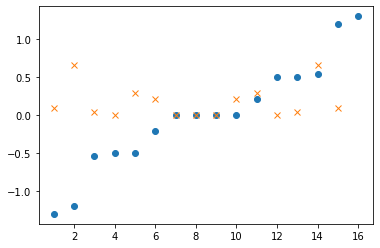

In [20]:
ee = la.eigvals(Htot)
sort_ee = np.sort(ee)
gap = np.zeros(len(ee)-1)
sort_gap = np.zeros(len(ee)-1)
block = []

for i in range(len(ee) - 1):
    gap[i] = sort_ee[i + 1] - sort_ee[i]

sort_gap = np.sort(gap)

numOfBlock = 0
block.append([])
block[0].append(0)

for i in range(len(ee)-1):
    if(gap[i] > gap[4]):
        numOfBlock = numOfBlock + 1
    # else:
    #     block.append([])
    #     numOfBlock = numOfBlock + 1

# np_ee = np.zeros(2**4)
# for i in range(len(ee)):
#     np_ee[i] = ee[i]
# ee = np.sort(ee)
plt.plot(np.linspace(1,len(sort_ee),len(sort_ee)),sort_ee,"o")
plt.plot(np.linspace(1,len(gap),len(gap)),gap,"x")
print(block)

In [21]:
numOfBlock

3